#### **Processamento de Áudio e Imagem** (2º semestre de 2024)

### **Experiência: Conversão da taxa de amostragem**


##### **Nome:** Ivan Matos

##### 10 de outubro de 2024

---
---

**Enunciado:**

O arquivo ``sinal.mat`` contém um sinal amostrado à taxa $f_a = 8 \, \textrm{kHz}$.  Trata-se de um pulso com vários picos.  Você precisa determinar as amplitudes dos picos positivos. 

Sabe-se que o sinal original tem banda até aproximadamente 3,5 kHz.  Proponha um procedimento para estimar com precisão as amplitudes dos picos positivos.

Use $\delta_p = 0,01$ e $\delta_r = 0,001$.

**Solução:**

In [1]:
using Plots, DSP, LaTeXStrings, MAT

In [2]:
x = matread("sinal.mat")["x"]
Ta = matread("sinal.mat")["Ta"]     # período de amostragem

0.000125

Plotemos o sinal:

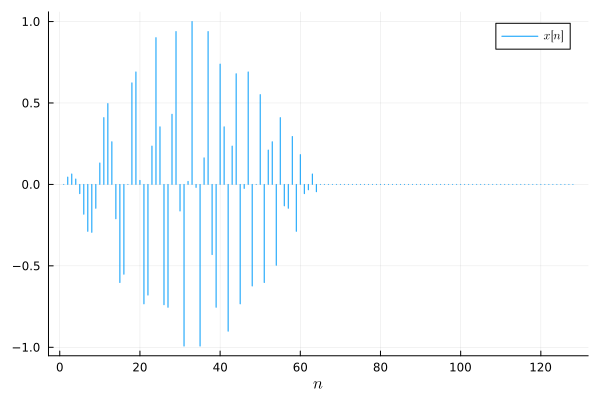

In [3]:
plot(x, line=:stem, label=L"$x[n]$")
xlabel!(L"$n$")

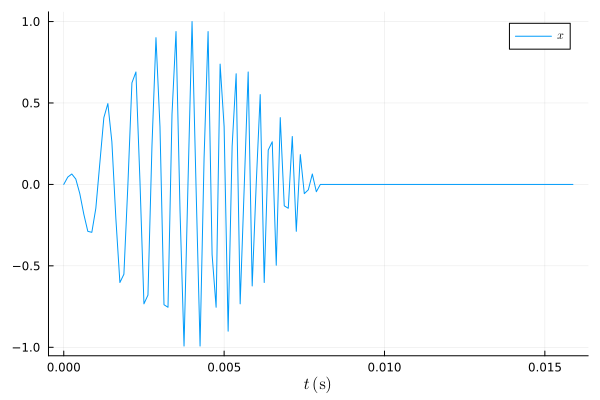

In [4]:
plot(Ta*(0:length(x)-1), x, label=L"$x$")
xlabel!(L"$t \; (\textrm{s})$")

**Aumento da taxa de amostragem por um fator $L$:**

Primeiramente, definimos uma função que insere $L-1$ amostras nulas entre cada duas amostras consecutivas do sinal $x[n]$ original.

In [5]:
function insere_zeros(x, L)

    x_L = zeros(length(x) * L)

    for i=1:length(x)
        x_L[L*(i-1) + 1] = x[i]
    end

    return x_L

end

insere_zeros (generic function with 1 method)

#### **Projeto de filtro passa-baixas:**

O sinal original tem banda até a frequência (normalizada) dada por

$$\omega_M = 2 \pi \cdot (3500 \, \textrm{Hz}) / f_a = 2 \pi \cdot 3500 / 8000 = \frac{7\pi}{8}$$

In [6]:
# omega_M = 7 * pi / 8

fmax = 3500     # frequência máxima da banda do sinal (em Hz)
fa = 1/Ta       # frequência de amostragem (em Hz)

omega_M = 2 * pi * fmax / fa

2.748893571891069

**Vamos escolher o valor de $L$:**

In [7]:
L = 10

10

O valor escolhido para $L$ foi obtido a partir de diferentes testes, em que observou-se quão bem os picos eram identificados, de acordo com $L$.

Consideremos o sinal $x_i$ obtido inserindo-se $L-1$ amostras nulas entre cada duas amostras consecutivas do sinal original. A TFTD do sinal resultante corresponde à TFTD do sinal original, "comprimida" por $L$ na escala horizontal (frequência). 

Para o projeto do filtro passa-baixas, usaremos **janela de Kaiser**. Tomaremos:

$$\omega_p = \frac{\omega_M}{L}$$

e 

$$\omega_r = \frac{2\pi}{L} - \frac{\omega_M}{L}$$



In [8]:
omega_p = omega_M / L

omega_r = 2*pi / L - omega_M / L

0.3534291735288517

Tomaremos como frequência de corte do filtro passa-baixas: 

$$\omega_c = \frac{\omega_p + \omega_r}{2} $$

Notemos que, de fato, tem-se $\omega_c = \frac{\pi}{L}$, como desejado (conforme visto em aula).

In [9]:
omega_c = (omega_p + omega_r) / 2   # omega_c = pi / L

0.3141592653589793

Usaremos $\delta_p = 0,01$ e $\delta_r = 0,001$.

In [10]:
delta_p = 0.01
delta_r = 0.001

0.001

Cálculo de $A$:

In [11]:
A = max(-20*log10(delta_p), -20*log10(delta_r))

60.0

Como $A > 50$, temos $\beta = 0,1102 \cdot (A-8,7)$ :

In [12]:
beta = 0.1102 * (A - 8.7)

5.65326

Calculemos $\Delta\omega = \omega_r - \omega_p = \big( \frac{2\pi}{L} - \frac{\omega_M}{L} \big) - \frac{\omega_M}{L} = \frac{2}{L}(\pi - \omega_M)$ :

In [13]:
delta_omega = omega_r - omega_p

0.07853981633974483

**OBSERVAÇÃO:** Há um compromisso entre a escolha do fator $L$ e o tamanho do filtro passa-baixas que deve ser projetado. Quanto maior $L$, menor será $\Delta\omega$, e, portanto, maior será o comprimento do filtro. Consequentemente, o regime transitório terá uma maior duração.

Cálculo de $N$:

In [14]:
N = (A - 8) / (2.285 * delta_omega) + 1

290.7525440972799

In [15]:
if (ceil(Int, N) % 2 != 0)
    N = ceil(Int, N)
else
    N = floor(Int, N)
end

print("N = ", N)

N = 291

Obtemos agora a janela de Kaiser $w[n]$:

In [16]:
w = kaiser(N, beta/pi)

291-element Vector{Float64}:
 0.020388000239333876
 0.02268933748715753
 0.025100945463930983
 0.027624739555522373
 0.030262584680846378
 0.03301629269365973
 0.03588761980402069
 0.03887826402236339
 0.0419898626291398
 0.045223989672975216
 ⋮
 0.0419898626291398
 0.03887826402236339
 0.03588761980402069
 0.03301629269365973
 0.030262584680846378
 0.027624739555522373
 0.025100945463930983
 0.02268933748715753
 0.020388000239333876

**Observação:** Na banda passante, o filtro deve apresentar um ganho igual a $L$, uma vez que o espectro do sinal obtido pela inserção de zeros tem módulo dividido por $L$.

Finalmente, obtemos os coeficientes $h[n]$ do filtro passa-baixas:

In [17]:
Lf = (N-1) / 2      # comprimento da janela de Kaiser

n = 0:N-1

hd = (omega_c/pi) * sinc.((omega_c/pi) * (n .- Lf))

h = L * hd .* w     # coeficientes do FPB (Atenção: multiplicamos por L)

291-element Vector{Float64}:
  0.00044756565763430777
  0.00047699714070636843
  0.0004520243335544199
  0.00036398095523441183
  0.00021111514818137125
  0.0
 -0.000253958262116428
 -0.0005271043386264672
 -0.0007892810185585582
 -0.001006668357655197
  ⋮
 -0.0007892810185585516
 -0.0005271043386264672
 -0.0002539582621164236
  0.0
  0.00021111514818137486
  0.0003639809552344172
  0.0004520243335544199
  0.00047699714070636935
  0.00044756565763430777

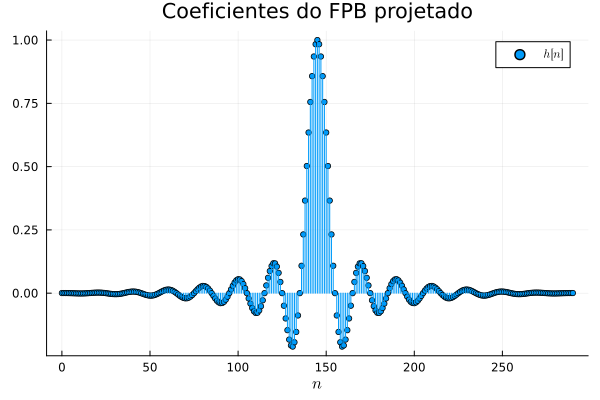

In [18]:
plot(n, h, label=L"h[n]", line = :stem, marker = (:circle, 3))
title!("Coeficientes do FPB projetado")
xlabel!(L"$n$")

Plotamos a resposta em frequência $H(e^{j \omega})$ do filtro obtido:

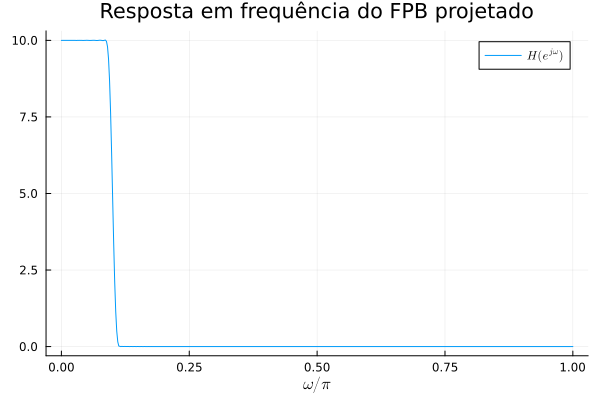

In [19]:
omegas = range(0,pi, length=500);

hf = PolynomialRatio(h, [1])

H = freqresp(hf, omegas)
plot(omegas/pi, abs.(H), label=L"$H(e^{j \omega})$")
xlabel!(L"\omega/\pi")
title!("Resposta em frequência do FPB projetado")

**Interpolação do sinal:**

In [20]:
x_i = insere_zeros(x, L)  # Sinal obtido inserindo-se L-1 zeros entre amostras do sinal original

x_i_filtrado = filt(hf, x_i)    # Sinal interpolado resultante

1280-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

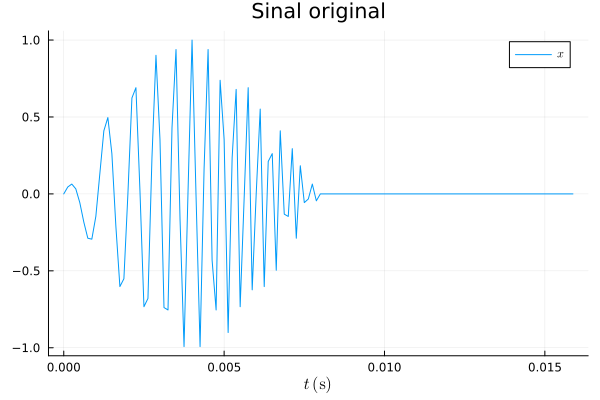

In [21]:
plot(Ta*(0:length(x)-1), x, label=L"$x$")
title!("Sinal original")
xlabel!(L"$t \; (\textrm{s})$")

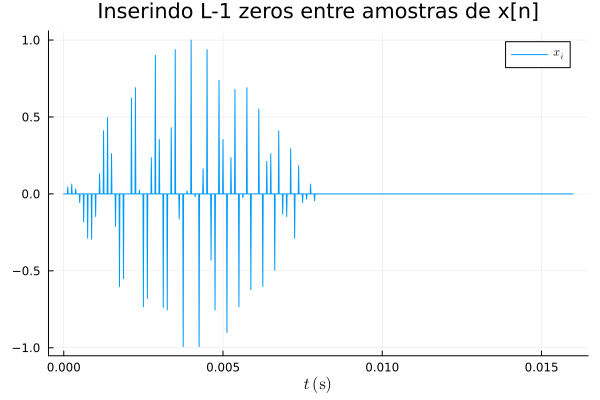

In [22]:
plot((Ta/L)*(0:length(x_i)-1), x_i, label=L"$x_i$")
title!("Inserindo L-1 zeros entre amostras de x[n]")
xlabel!(L"$t \; (\textrm{s})$")

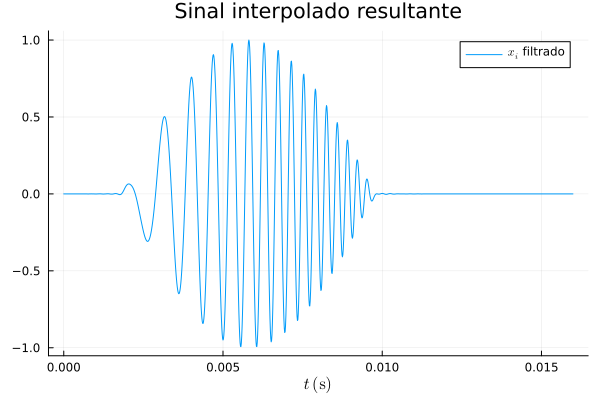

In [23]:
plot((Ta/L)*(0:length(x_i_filtrado)-1), x_i_filtrado, label=L"$x_i$ filtrado")
title!("Sinal interpolado resultante")
xlabel!(L"$t \; (\textrm{s})$")

##### **Identificação dos picos positivos do sinal**

Uma estratégia para identificar os picos do sinal consiste em calcular sua derivada "digital" e selecionar as amostras para as quais a derivada transita de um valor positivo para um valor negativo.

In [24]:
derivada = diff(x_i_filtrado)

1279-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 2.013119426985831e-5
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

Observação: selecionaremos apenas os picos superiores a 0.01.

A seguir, apresentamos os valores estimados dos picos, e indicamos os pontos correspondentes no gráfico do sinal interpolado.

In [25]:
indices_picos = Vector{Int}()

print("Valores estimados dos picos:\n\n")

for i=1:length(derivada)-1
    if (derivada[i] > 0) & (derivada[i+1] <= 0) & (x_i_filtrado[i+1] > 0.01)
        print(x_i_filtrado[i], "\n")
        append!(indices_picos, i)
    end
end

Valores estimados dos picos:

0.06431627334104585
0.5010705475297799
0.7559732661590306
0.9011148777273202
0.9696544928868854
0.987564992576866
0.9603219692258399
0.9296399995462152
0.8598536542256046
0.7728375943109207
0.661252295117044
0.5543573574823073
0.4500573660828932
0.34615149592035466
0.20943141539159024
0.0896332448744457


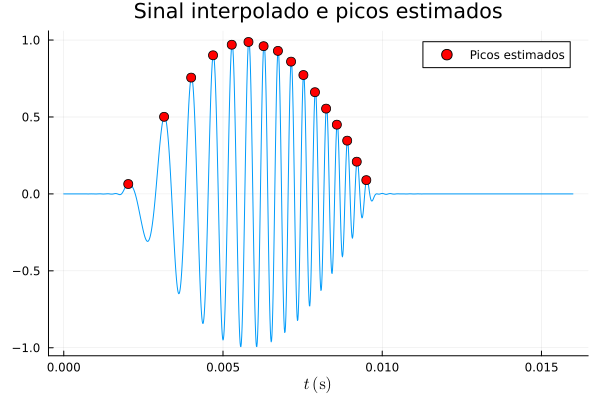

In [26]:
plot((Ta/L)*(0:length(x_i_filtrado)-1), x_i_filtrado, label=false)
scatter!((Ta/L)*(indices_picos.-1), x_i_filtrado[indices_picos], color="red", markersize=5, label="Picos estimados")
title!("Sinal interpolado e picos estimados")
xlabel!(L"$t \; (\textrm{s})$")

**ALTERNATIVA:**

Para identificar os picos positivos do sinal, podemos utilizar também o pacote ``FindPeaks1D``.

In [27]:
using FindPeaks1D

In [28]:
pkindices, properties = findpeaks1d(x_i_filtrado)

# plot(x_i_filtrado, label=false)
# scatter!(pkindices, x_i_filtrado[pkindices]; color="red", markersize=5, label="peaks")

indices_relevantes = Vector{Int}()

print("Valores estimados dos picos:\n\n")

for i in pkindices
    if x_i_filtrado[i] > 0.01
        print(x_i_filtrado[i], "\n")
        append!(indices_relevantes, i)
    end
end

Valores estimados dos picos:

0.06474475345303977
0.5027305018230283
0.7595439526646238
0.9052767303167506
0.9789343399075074
1.0
0.9817224560749902
0.9324105343364373
0.863026767165536
0.7784686156746906
0.6813621632508572
0.5744143775257055
0.4639842165404143
0.3500016922400556
0.22105098989182917
0.09660672385069106


Notamos que os picos estimados usando a função ``findpeaks1d`` (do pacote ``FindPeaks1D``) são compativeis àqueles encontrados a partir do cálculo da derivada do sinal.

In [29]:
indices_relevantes

16-element Vector{Int64}:
 164
 254
 322
 377
 424
 466
 504
 540
 573
 604
 633
 661
 688
 714
 738
 762

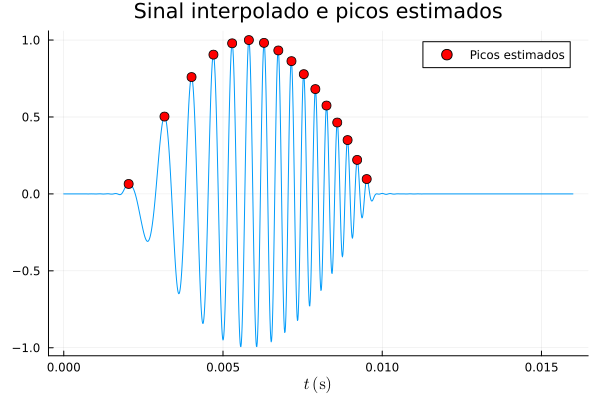

In [30]:
plot((Ta/L)*(0:length(x_i_filtrado)-1), x_i_filtrado, label=false)
scatter!((Ta/L)*(indices_relevantes.-1), x_i_filtrado[indices_relevantes], color="red", markersize=5, label="Picos estimados")
title!("Sinal interpolado e picos estimados")
xlabel!(L"$t \; (\textrm{s})$")